In [2]:
print("Hello jupyter!")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import tensorflow.keras
import coremltools
# import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Hello jupyter!
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Import the dataset and process it

dataframe = pd.read_csv("./fullDataset.csv")
dataframe = dataframe.drop(columns=['Unnamed: 0'])
raw_data = dataframe.values
dataframe.head()
print(len(dataframe))
# x_train,x_test,y_train,y_test=train_test_split(raw_data,y,test_size=0.2)

# Import evaluation dataset

evaluation = pd.read_csv("./testCadDataset.csv")
evaluation = evaluation.drop(columns=['Unnamed: 0'])
raw_data_evaluation = evaluation.values
evaluation.head()

128790


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,1.0,0.927143,0.722857,0.498571,0.262857,0.065714,0.000000,0.030000,0.060000,0.065714,...,0.131429,0.128571,0.137143,0.142857,0.140000,0.142857,0.211429,0.375714,0.622857,0.898571
1,1.0,0.867470,0.551205,0.182229,0.024096,0.055723,0.039157,0.006024,0.006024,0.004518,...,0.060241,0.057229,0.057229,0.060241,0.063253,0.078313,0.135542,0.278614,0.496988,0.801205
2,1.0,0.673517,0.169393,0.000000,0.042973,0.084825,0.087659,0.090533,0.074627,0.091872,...,0.161204,0.131341,0.118093,0.112857,0.156913,0.167700,0.164865,0.162188,0.248804,0.618280
3,1.0,0.881988,0.623851,0.373747,0.194203,0.057143,0.000000,0.008696,0.023188,0.025010,...,0.052174,0.057226,0.063437,0.069565,0.074865,0.134990,0.247371,0.416149,0.636190,0.867909
4,1.0,0.795209,0.565378,0.446569,0.202309,0.020710,0.000000,0.030493,0.034333,0.029856,...,0.085006,0.082417,0.070662,0.067182,0.067182,0.071319,0.107839,0.239910,0.457073,0.750562


In [3]:
full_length = len(raw_data)
separation_full = np.arange((full_length))
separation_full_list = separation_full.tolist()
separation_train = random.sample(separation_full_list, int(0.8 * full_length))
test = dataframe
train = dataframe.iloc[separation_train,:]
# test = dataframe.drop(dataframe.loc[separation_train,].index, inplace=True)
# print(len(test))
test.drop(dataframe.loc[separation_train,].index, inplace=True)
print(len(test))
print(len(train))


25758
103032


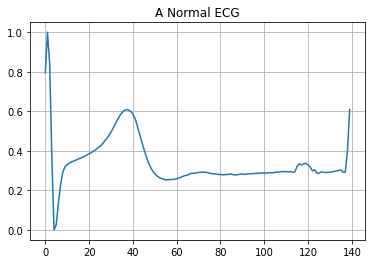

In [4]:
plt.grid()
plt.plot(np.arange(140), raw_data[0,:])
plt.title("A Normal ECG")
plt.show()

In [5]:
# Build the model
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [6]:
# Train the model
history = autoencoder.fit(train, train, 
          epochs=20, 
          batch_size=512,
          validation_data=(test, test),
          shuffle=True)


Epoch 1/20
202/202 [==============================] - 7s 4ms/step - loss: 0.1681 - val_loss: 0.0449
Epoch 2/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0425 - val_loss: 0.0361
Epoch 3/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0319 - val_loss: 0.0265
Epoch 4/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0261 - val_loss: 0.0251
Epoch 5/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0249 - val_loss: 0.0244
Epoch 6/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0242 - val_loss: 0.0238
Epoch 7/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0234
Epoch 8/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0231
Epoch 9/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0222
Epoch 10/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0218 - val_loss: 0.0213

<class 'numpy.ndarray'>
(128790, 140)


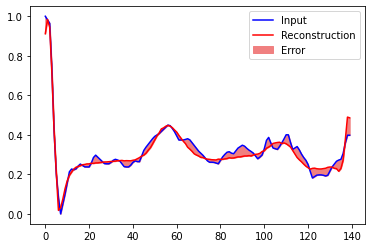

tf.Tensor(0.02353019610881556, shape=(), dtype=float64)
<class '__main__.AnomalyDetector'>


In [8]:
# Plot a normal example:
print(type(raw_data))
print(raw_data.shape)

encoded_imgs = autoencoder.encoder(raw_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
index = 15200
plt.plot(raw_data[index], 'b')
plt.plot(decoded_imgs[index], 'r')
plt.fill_between(np.arange(140), decoded_imgs[index], raw_data[index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()
train_loss1 = tf.keras.losses.mae(decoded_imgs[index], raw_data[index])
print(train_loss1)
print(type(autoencoder))


Threshold:  0.04304970990934394


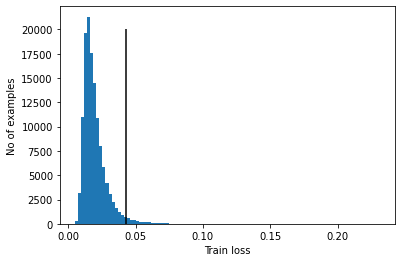

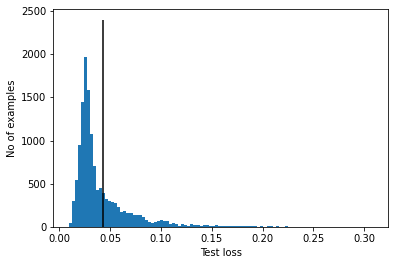

In [7]:
# Plot the reconstruction error on normal data

reconstructions = autoencoder.predict(raw_data)
train_loss = tf.keras.losses.mae(reconstructions, raw_data).numpy()

threshold = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold: ", threshold)

plt.hist(train_loss, bins=100)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.vlines(x=threshold, ymin=0, ymax=20000, colors='black')
plt.show()


reconstructions = autoencoder.predict(raw_data_evaluation)
train_loss = tf.keras.losses.mae(reconstructions, raw_data_evaluation).numpy()

# threshold = np.mean(train_loss) + 1.5*np.std(train_loss)
# print("Threshold: ", threshold)

plt.hist(train_loss, bins=100)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.vlines(x=threshold, ymin=0, ymax=2400, colors='black')
plt.show()

In [ ]:
# Plot an anomalous #example:

encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

test_ind = 10
plt.plot(anomalous_test_data[test_ind], 'b')
plt.plot(decoded_imgs[test_ind], 'r')
plt.fill_between(np.arange(140), decoded_imgs[test_ind], anomalous_test_data[test_ind], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [11]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))


preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

NameError: name 'test_data' is not defined

In [3]:
# Save and load the model

# autoencoder.save("./autoencoder")
autoencoder = tensorflow.keras.models.load_model('./autoencoder')


In [4]:
mlmodel = coremltools.convert(autoencoder)

Translating MIL ==> MLModel Ops: 100%|██████████| 24/24 [00:00<00:00, 12062.71 ops/s]


In [5]:
mlmodel.save('./checkRRfinal.mlmodel')